# Analyse
Im Folgenden befindet sich Code, welcher zur Analyse der Daten verwendet wird.

Dieses Notebook ist aufgeteilt in:
- [Funktionsbereich](#Funktionsbereich)
- [Playground](#Playground-Bereich)
- [Grafiken](#Grafik-Bereich)

## Funktionsbereich
In diesem Bereich befinden sich die Funktionen. Die einzelnen Zellen müssen daher beim Neustart des Notebooks zuerst noch ausgeführt werden, damit die entsprechenden Funktionen im weiteren Verlauf zur Verfügung stehen.

### Bibliotheken
Importieren der notwendigen Bibliotheken

In [1]:
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt

### Konstanten
Hier werden verschiedene Konstanten festgelegt. Unter anderem befindet sich hier das Mapping, welches die Probanden IDs auf die Eigenschaften (**Geschlecht** und **Alter**) mappt, um diese in anderen Funktionen
nutzen zu können.

In [2]:
subjects = {
    1: ["male", 52],
    2: ["male", 40],
    3: ["female", 35],
    4: ["female", 44],
    5: ["male", 21],
    6: ["female", 21],
    7: ["male", 51],
    8: ["female", 51],
    9: ["male", 14],
    10: ["male", 23],
    11: ["female", 23],
    12: ["male", 52]
}

path_to_data = "../Daten/"
path_to_csvs = "../CSV_Data/"

### Funktionen
Hier finden sich die Funktionen im Funktionsbereich

In [3]:
# Verwandelt eine Log Datei in eine CSV Datei (vorher muss Fehler Log entfernt werden)
def log_to_csv(*filenames):  
    for filename in filenames:
        with open(filename, "r") as file:
            _filename = os.path.basename(filename)
            with open(path_to_csvs + _filename.split(".txt")[0] + ".csv", "w", newline='') as csvfile:
                writer = csv.writer(csvfile, delimiter=",")
                writer.writerow(["event","timestamp","button","finger","word"])
                for line in file:
                    if "beginning" in line or "Proband" in line:
                        continue

                    data = line.split("{")[1].split("}")[0].split(",")
                    writer.writerow(data)

In [4]:
def get_raw_data():
    files = [path_to_data + file for file in os.listdir(path_to_data)]
    return files

In [5]:
def get_csv_data():
    files = [path_to_csvs + file for file in os.listdir(path_to_csvs)]
    return files

In [6]:
# Wandelt alle Basisdaten von .txt in .csv um
def generate_csv_files():
    log_to_csv(*get_raw_data())

In [60]:
def calc_time(*filenames):
    for filename in filenames:
        data = pd.read_csv(filename)
        start = data.query('event == "TRIAL_START"')["timestamp"]
        end = data.query('event == "TRIAL_END"')["timestamp"]
        time = (int(end) - int(start)) / 1000 / 60
        _filename = os.path.basename(filename).split("-")
        _id = _filename[0]
        mode = _filename[1].split(".")[0]
        yield (_id, mode, round(time, 2))

In [99]:
# Erzeugt ein Dict aus Worten und für das Wort notwendige Aktionen (kann verglichen werden)
def count_actions_for_word(filename):
    word_dict = dict()
    current = None
    data = pd.read_csv(filename)
    queried = data.query('event == "WORD_DONE"')
    sorted = queried.sort_values(by="timestamp", ascending=True)
    for index, row in sorted.iterrows():
        word = row["word"]
        started_index = data.query('event == "WORD_NEXT" and word == @word')
        word_dict[word] = index - started_index.index.values[0]
    return word_dict

In [9]:
# Erzeugt ein Dict aus Worten und für das Wort benötigte Zeit
def count_speed_for_word(*filenames):
    with open(path_to_csvs + "word_speeds.csv", "w", newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(["id", "sex", "age", "mode", "word", "length", "time", "actions"])

        for filename in filenames:
            if not ("drea" or "normal") in filename:
                continue
            word_actions = count_actions_for_word(filename)
            old = None
            old_word = None
            counter = 0
            with open(filename, "r") as file:
                for line in file:
                    # Wenn das nächste Wort angezeigt wird
                    if "WORD" in line:
                        data = line.split(",")
                        
                    if "WORD_NEXT" in line:
                        # Test ob es das erste Wort ist
                        if old_word == None:
                            old_word = data
                            continue
                            
                        old_word = data
                        
                    if "WORD_DONE" in line:
                        _id = get_id(filename)
                        mode = get_mode(filename)
                        word = old_word[4].strip()
                        actions = word_actions[word]
                        time = (int(data[1]) - int(old_word[1])) / 1000 
                        csvData = [_id] + subjects[int(_id)] + [mode, word, len(word), time, actions]
                        writer.writerow(csvData)

In [10]:
def get_id(filename):
    _filename = os.path.basename(filename).split("-")
    return int(_filename[0])

In [11]:
def get_mode(filename):
    _filename = os.path.basename(filename).split("-")
    mode = _filename[1].split(".")[0]
    return mode

In [12]:
def speed_by_id(*filenames): 
    for filename in filenames:
        speed = pd.read_csv(path_to_csvs + filename)
        event_filter = speed["event"] == "CHAR_CLICKED"
        inverted = speed[event_filter].sort_values(by="timestamp", ascending=False)
        times = []
        old = None
        for time in inverted["timestamp"]:
            if old == None:
                old = time
                continue
            else:
                times.append((old - time) / 1000)
                old = time
        yield pd.Series(times[::-1])

In [13]:
# Funktion zum Analysieren der Geschwindigkeit der einzelnen Buchstaben

### WICHTIG ### Zu wenig Datenpunkte für eine richtige Analyse ### WICHTIG ###
def get_speed_for_chars(filename):
    data = pd.read_csv(filename)
    trial_start = data[data["event"] == "TRIAL_START"]["timestamp"]
    char_event_filter = data["event"] == "CHAR_CLICKED"
    clicked = data[char_event_filter].sort_values(by="timestamp", ascending=True)
    old = None
    char_dict = dict()
    char_list = []
    for index, row in clicked.iterrows():
        time = row["timestamp"]
        if old == None:
            old = time
            char_list.append([row["button"], (old - int(trial_start)) / 1000, time])
        else:     
            char_list.append([row["button"], (time - old) / 1000, time])
            old = time
    df = pd.DataFrame(char_list, columns=["button", "time", "timestamp"])
    return df

In [100]:
def calc_typing_speed(filename):
    with open(filename, "r") as file:
        old = None
        speeds = []
        for line in file:
            if "CHAR_CLICKED" in line:
                data = line.split(",")
                current = int(data[1])
                if old == None:
                    old = current
                else:
                    speeds.append((current - old) / 1000)
                    old = current
                
    return speeds

## Playground Bereich
Hier werden verschiedene Funktionen getestet, und Daten analysiert

In [14]:
generate_csv_files()

In [37]:
count_speed_for_word(*get_csv_data())

In [89]:
with open(path_to_data + "interactions.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["id", "sex", "age", "actions_drea", "actions_normal", "difference"])

    for i in range(1, 13):
        #print("######################\n")
        drea = count_actions_for_word(f"{path_to_data}{str(i).zfill(2)}-drea.csv")
        normal = count_actions_for_word(f"{path_to_data}{str(i).zfill(2)}-normal.csv")
        drea_counter = 0
        normal_counter = 0
        for key, value in drea.items():
            drea_counter += drea[key]
            normal_counter += normal[key]
            #print(f"Wort: {key}; Drea Modus: {drea[key]}; Normaler Modus: {normal[key]}")
            #print(key)
            #print(f"Im DREA Modus waren es {normal[key] - drea[key]} weniger/mehr")
        writer.writerow([i] + subjects[i] + [drea_counter, normal_counter, normal_counter - drea_counter])
        #print(f"\nInsgesamt waren es {drea_counter} Interaktionen im DREA Modus")
        #print(f"Insgesamt waren es {normal_counter} Interaktionen im normal Modus\n")
        #print("######################\n")

In [98]:
interactionData = pd.read_csv(path_to_data + "interactions.csv")
#time_filter = interactionData["time"] < 20
actions_diff = interactionData["actions_drea"] < interactionData["actions_normal"]

#_filter = time_filter & mode_filter
#timedata[_filter]
#interactionData[actions_diff]
interactionData.sort_values(by = "difference", ascending=False)

,id,sex,age,actions_drea,actions_normal,difference
1,2,male,40,1195,2128,933
10,11,female,23,1171,2058,887
5,6,female,21,971,1842,871
8,9,male,14,973,1768,795
4,5,male,21,946,1646,700
7,8,female,51,1183,1796,613
9,10,male,23,1106,1694,588
2,3,female,35,1792,2042,250
3,4,female,44,1542,1750,208
0,1,male,52,1649,1766,117


In [101]:
timedata = pd.read_csv(path_to_data + "time.csv")
time_filter = timedata["time"] < 20
mode_filter = timedata["mode"] == "drea"

_filter = time_filter & mode_filter
timedata[_filter].sort_values(by = "time")

,id,mode,time,sex,age
8,5,drea,13.48,male,21
16,9,drea,13.94,male,14
10,6,drea,15.05,female,21
20,11,drea,18.21,female,23
2,2,drea,20.37,male,40
18,10,drea,21.83,male,23
14,8,drea,24.31,female,51
0,1,drea,24.59,male,52
22,12,drea,24.67,male,52
12,7,drea,26.13,male,51


In [62]:
with open(path_to_csvs + "time.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["id", "mode", "time", "sex", "age"])
    for i in range(1, 13):
            try:
                filename_drea = f"{path_to_data}{str(i).zfill(2)}-drea.csv"
                filename_normal = f"{path_to_data}{str(i).zfill(2)}-normal.csv"
                for run in calc_time(filename_drea, filename_normal):
                    subject = list(run) + subjects[i]
                    writer.writerow(subject)
            except:
                print("Fehler")

Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler
Fehler


## Grafik Bereich
Hier werden verschiedene Grafiken erzeugt (z.B. Boxplots) um die Daten zu analysieren

In [17]:
df = pd.read_csv(path_to_csvs + "word_speeds.csv")
_filter = df["word"] == "Auto"
_filter2 = df["mode"] == "drea"
_filter3 = df["mode"] == "normal"

C:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


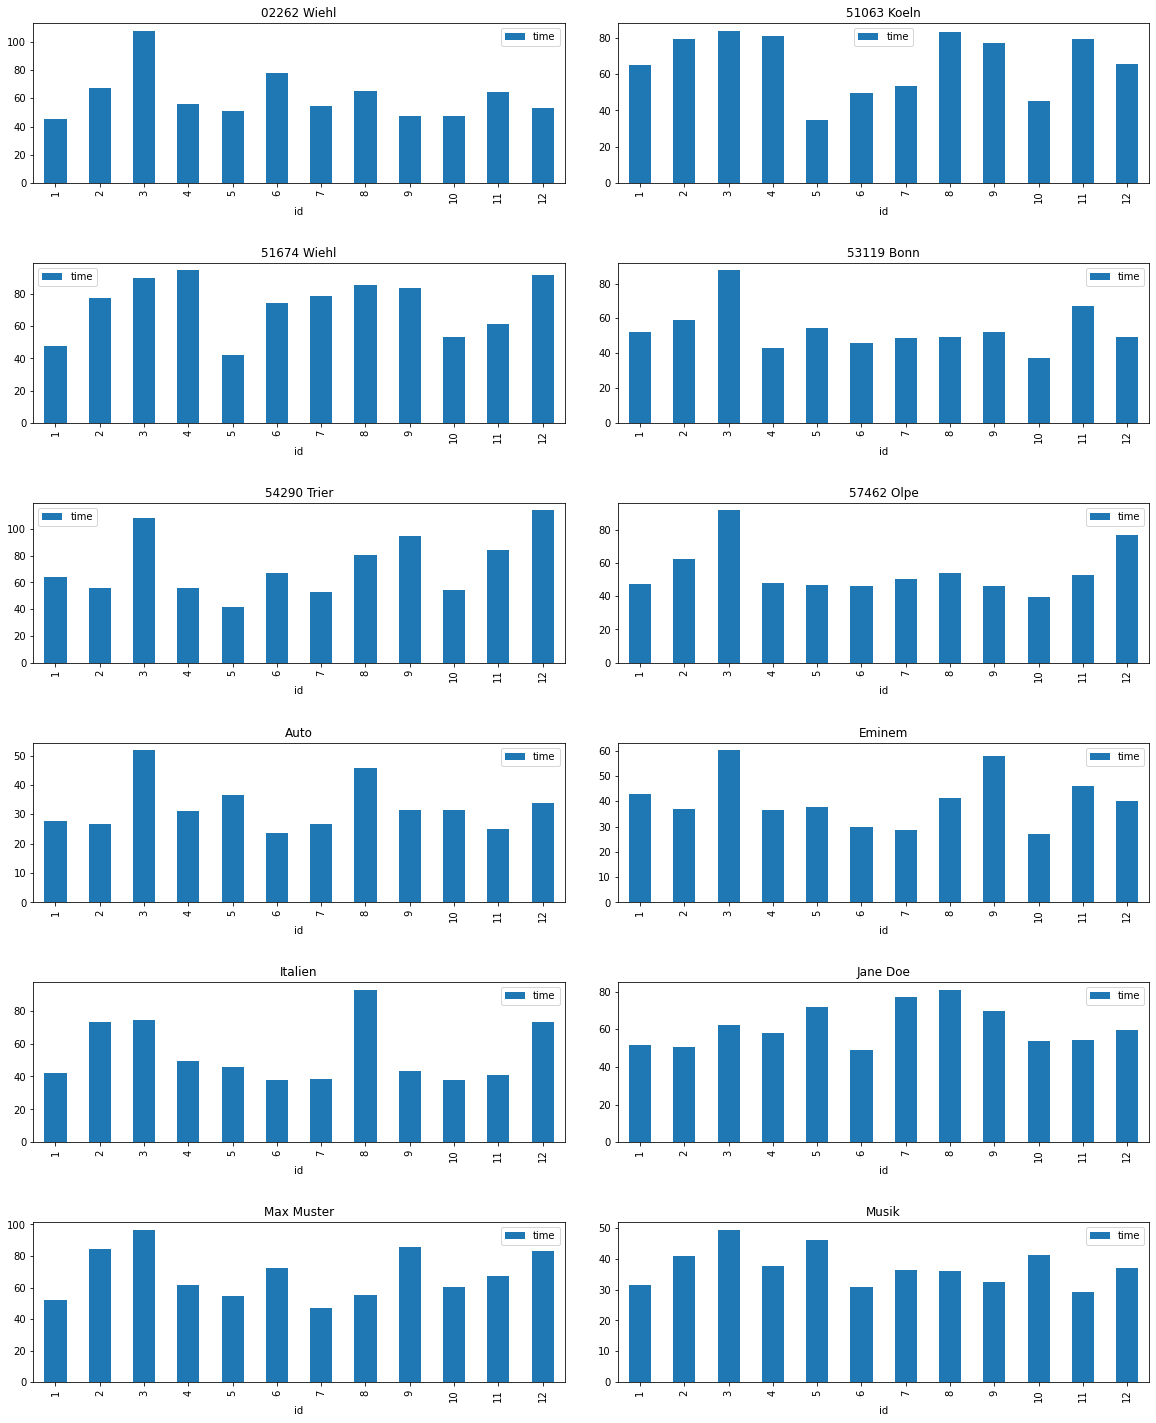

In [145]:
fig, ax = plt.subplots(6, 2, figsize=(20,25))
sorted_by_words = df.sort_values(by=["word", "id"])
grouped = sorted_by_words[_filter3].groupby(by="word")
ycounter = 0
xcounter = 0
for name, group in grouped:
    if ycounter == 6:
        break
    group.plot(y="time", x="id", kind="bar", ax=ax[ycounter, xcounter], title=name)
    if xcounter == 1:
        ycounter += 1
        xcounter = 0
    else:
        xcounter += 1
# print(first.describe())
# print(last.describe())
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

              id        age     length        time     actions
count  60.000000  60.000000  60.000000   60.000000   60.000000
mean    6.500000  35.583333   7.833333   58.593833  108.000000
std     3.481184  14.000353   2.669137   22.782175   31.141558
min     1.000000  14.000000   4.000000   24.659000   42.000000
25%     3.750000  22.500000   5.000000   40.572000   86.000000
50%     6.500000  37.500000   7.000000   53.159500  103.500000
75%     9.250000  51.000000  11.000000   75.154500  133.000000
max    12.000000  52.000000  11.000000  114.024000  177.000000
              id        age     length       time     actions
count  60.000000  60.000000  60.000000  60.000000   60.000000
mean    6.500000  35.583333   6.916667  42.963250   87.683333
std     3.481184  14.000353   2.854029  16.353258   28.598027
min     1.000000  14.000000   4.000000  16.971000   30.000000
25%     3.750000  22.500000   4.000000  30.615000   68.500000
50%     6.500000  37.500000   6.000000  38.464500   90.000000

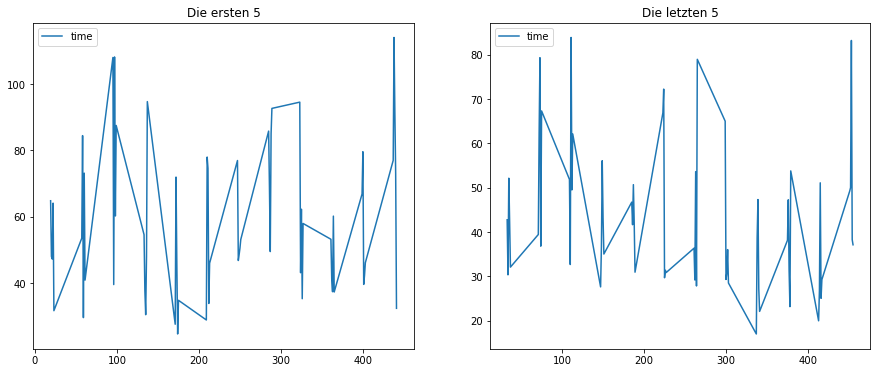

In [420]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
grouped = df[_filter3].groupby(by="id")
first = pd.concat([group[:5] for name, group in grouped])
last = pd.concat([group[-5:] for name, group in grouped])
first.plot(y="time", ax=ax[0], title="Die ersten 5")
last.plot(y="time", ax=ax[1], title="Die letzten 5")

print(first.describe())
print(last.describe())
plt.subplots_adjust(wspace=0.2) 
plt.show()

     id   sex  age  mode         word  length     time  actions
0     1  male   52  drea         Auto       4   67.775       67
1     1  male   52  drea         RPR1       4   50.803       52
2     1  male   52  drea  51063 Koeln      11   79.566      102
3     1  male   52  drea  54290 Trier      11  149.853      185
4     1  male   52  drea       Tanken       6   68.267       95
..   ..   ...  ...   ...          ...     ...      ...      ...
432  12  male   52  drea   Max Muster      10  103.666      137
433  12  male   52  drea        WDR 4       5   44.947       63
434  12  male   52  drea        Musik       5   46.875       66
435  12  male   52  drea         Auto       4   46.460       74
436  12  male   52  drea     Jane Doe       8   73.428      115

[228 rows x 8 columns]


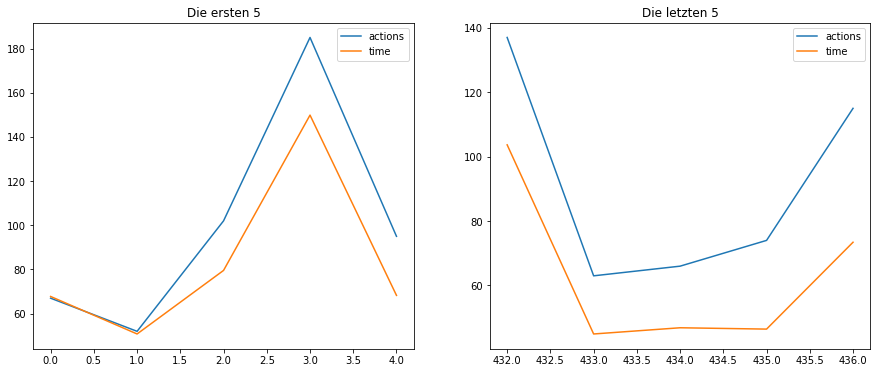

In [349]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
df[_filter2][:5].plot(y=["actions", "time"], ax=ax[0], title="Die ersten 5")
df[_filter2][-5:].plot(y=["actions", "time"], ax=ax[1], title="Die letzten 5")
plt.subplots_adjust(wspace=0.2) 

plt.show()

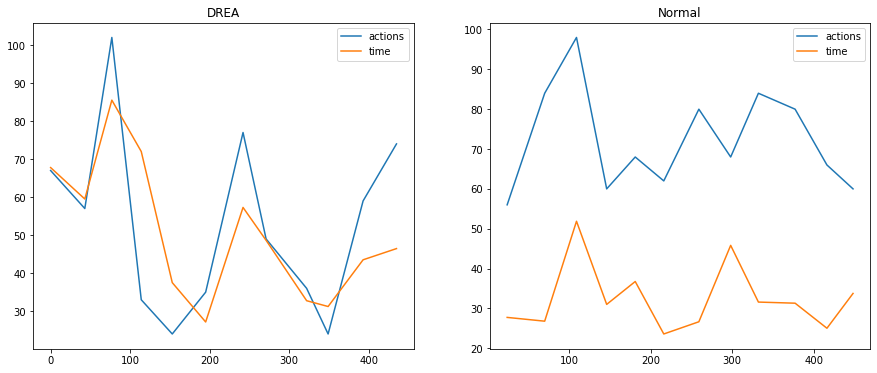

In [348]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
df[_filter & _filter2].plot(y=["actions", "time"], ax=ax[0], title="DREA")
df[_filter & _filter3].plot(y=["actions", "time"], ax=ax[1], title="Normal")
plt.subplots_adjust(wspace=0.2) 

plt.show()

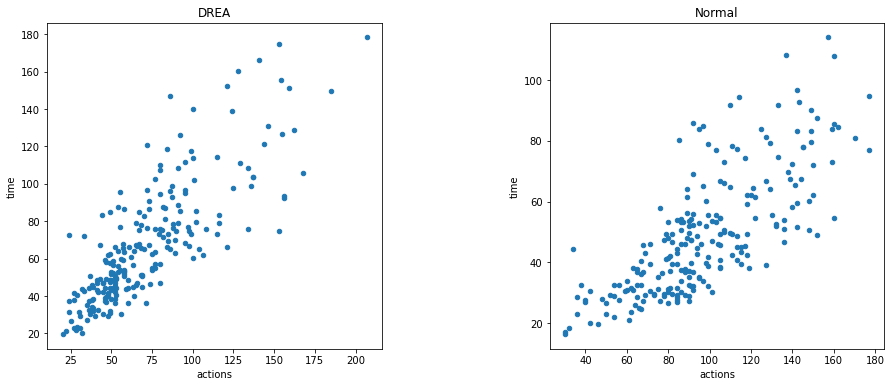

In [346]:
# df[_filter2].plot(
#     kind="box",
#     subplots=True,
#     sharey=False,
#     figsize=(10, 6)
# )

# plt.subplots_adjust(wspace=0.5)
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,6))
#df[_filter2].boxplot(column = ["actions", "time"], ax=ax[0]) 
# df[_filter2].boxplot("actions", ax=ax[0])
# df[_filter2].boxplot("time", ax=ax[1])
# df[_filter3].boxplot("actions", ax=ax[2])
# df[_filter3].boxplot("time", ax=ax[3])
#df.boxplot(by="mode", column=["actions", "time"], ax=ax[0])
df[_filter2].plot(kind="scatter", x="actions", y="time", ax=ax[0], title="DREA")
df[_filter3].plot(kind="scatter", x="actions", y="time", ax=ax[1], title="Normal")
plt.subplots_adjust(wspace=0.5) 

plt.show()

In [ ]:
fig, ax = plt.subplots(11, 2, figsize=(15,30))
files = get_csv_data()
ycounter = 0
xcounter = 0
for file in files:
    if "speeds" in file:
        continue
    if "tlx" in file:
        continue
    if "01" in file:
        continue
    if xcounter == 2:
        xcounter = 0
        ycounter += 1
        
    data = next(speed_by_id(file))
    data.plot(title=file, ax=ax[ycounter, xcounter])
    xcounter += 1
    
plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

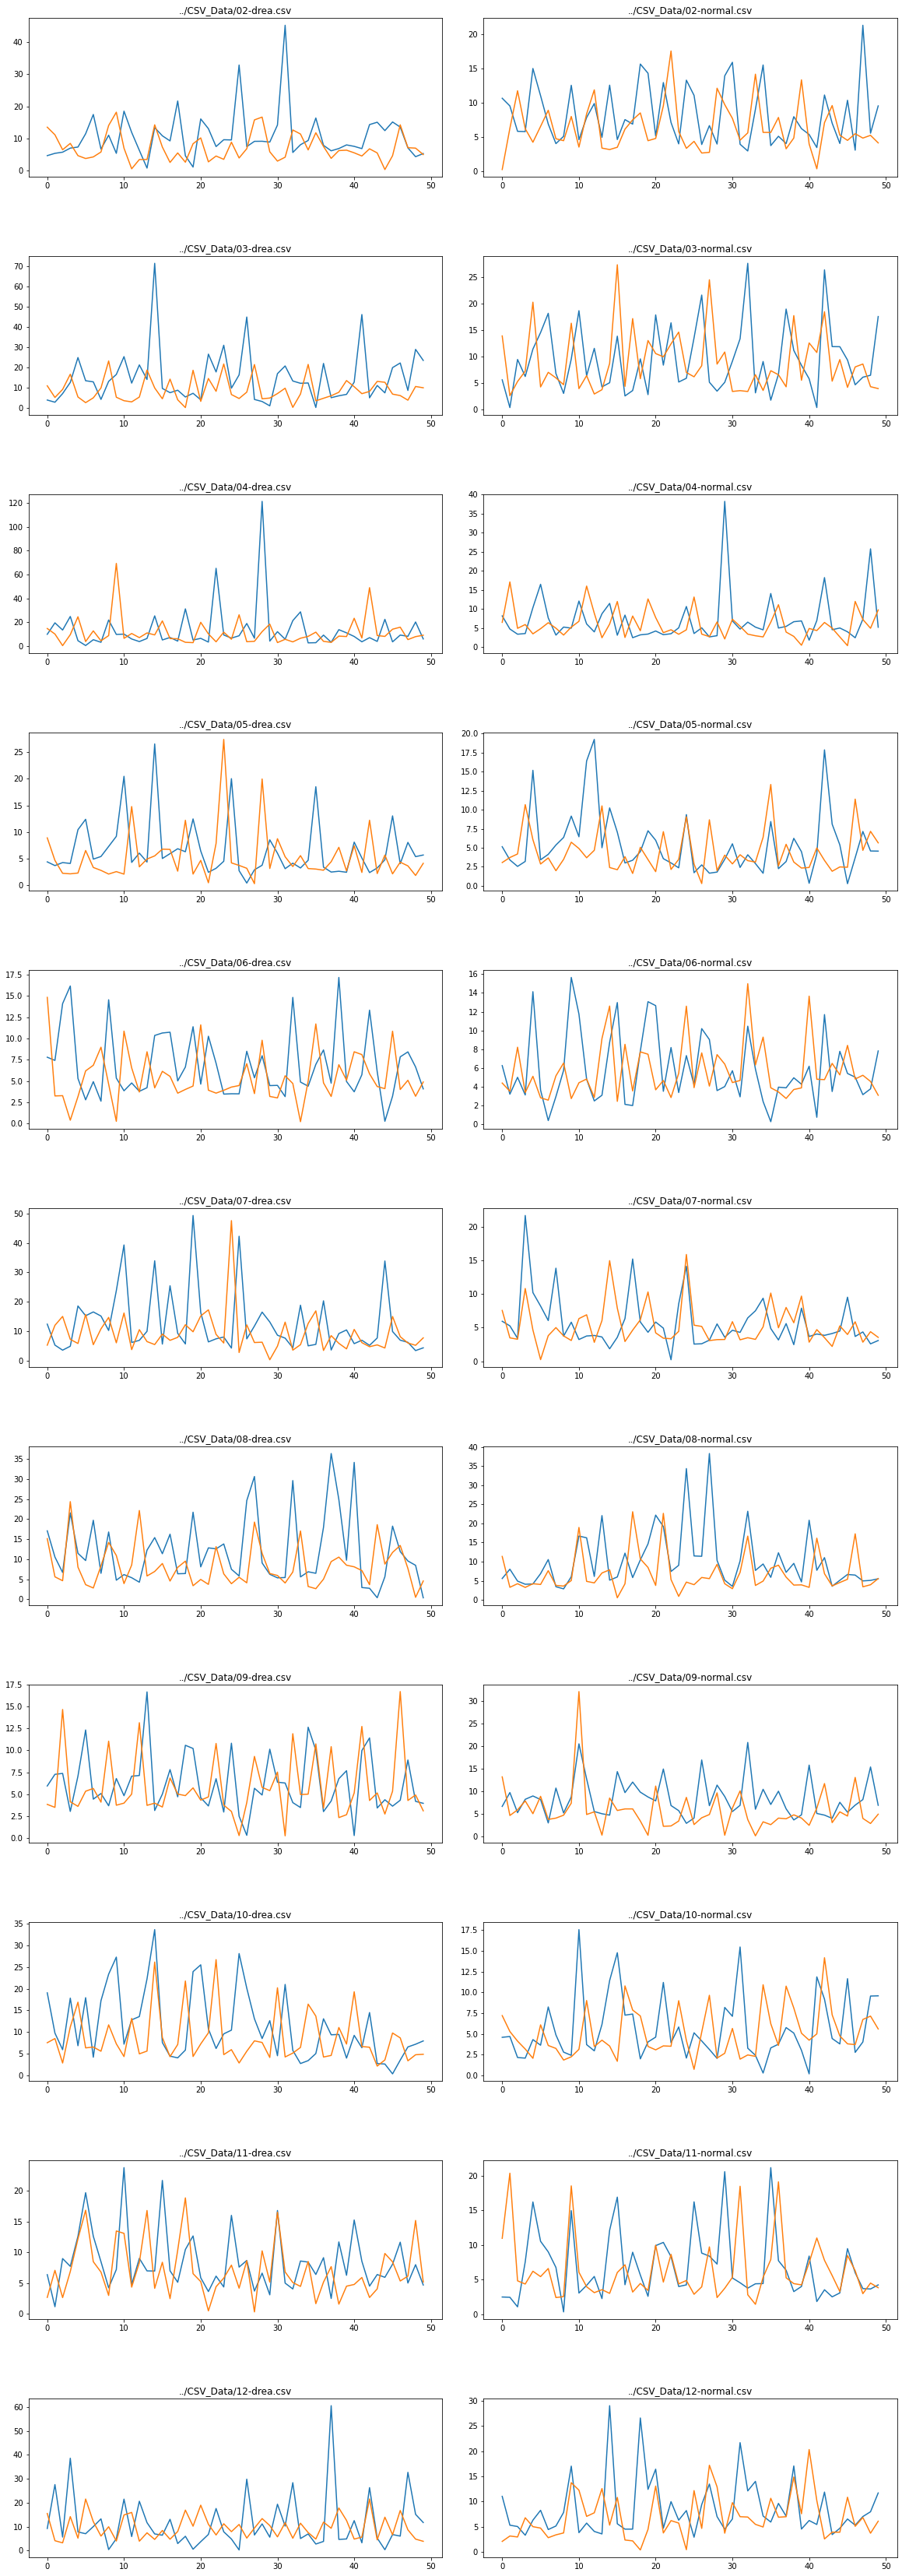

In [25]:
fig, ax = plt.subplots(11, 2, figsize=(20,60))
ycounter = 0
xcounter = 0
subCounter = 0
files = get_csv_data()

for file in files:
    if not "drea" in file and not "normal" in file:
        continue
        
    if "01" in file:
        continue
        
    if "drea" in file:
        subject_drea = next(speed_by_id(file))
        
        first_drea = subject_drea[:50]
        last_drea = subject_drea[-50:].reset_index(drop=True)

        first_drea.plot(ax=ax[ycounter][0])
        last_drea.plot(ax=ax[ycounter][0], title=file)
        
    if "normal" in file:
        subject_normal = next(speed_by_id(file))
        
        first_normal = subject_normal[:50]
        last_normal = subject_normal[-50:].reset_index(drop=True)

        first_normal.plot(ax=ax[ycounter][1])
        last_normal.plot(ax=ax[ycounter][1], title=file) 
        
    subCounter += 1
    
    if subCounter == 2:
        subCounter = 0
        ycounter += 1

plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

<AxesSubplot:>

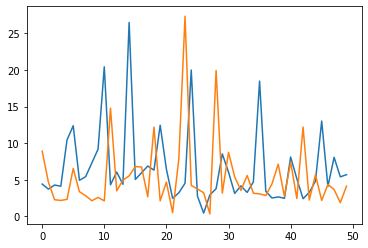

In [226]:
luca_drea = next(speed_by_id(path_to_csvs + "05-drea.csv"))
luca_normal = next(speed_by_id(path_to_csvs + "05-normal.csv"))

first = luca_drea[:50]
last = luca_drea[-50:].reset_index(drop=True)

first.plot()
last.plot()
# print("\n#################\n")
# print(luca_normal[:50].describe())
# print("\n#################\n")
# print(luca_normal[-50:].describe())

In [171]:
# Aufschlüsselung nach Personen die im DREA bzw. normalen Modus angefangen haben
# Es wird verglichen, wie diese Personen die unterschiedlichen Skalen empfunden haben
# Frage: Macht es einen Unterschied, ob im DREA oder normalen Modus angefangen wurde?

drea_ids = [1,2,5,7,10,11]
normal_ids = [3,4,6,8,9,12]


tlx_data = pd.read_csv(path_to_csvs + "tlx.csv")
drea_filter = tlx_data["mode"] == "drea"
normal_filter = tlx_data["mode"] == "normal"
scale = tlx_data["subscale"] == "mental-demand"
#filtered = tlx_data[drea_filter].groupby(by="subscale")
# tlx_data[drea_filter].boxplot("value",by="subscale", layout=(2,3), figsize=(30,15))
# tlx_data[normal_filter].boxplot("value",by="subscale", layout=(2,3), figsize=(30,15))
# luca_filter = tlx_data["subject"] == 6
# grouped = tlx_data[luca_filter].groupby("subscale")
# for name, group in grouped:
#     print(group)

tlx_data2 = tlx_data[tlx_data['subject'].isin(drea_ids)]
tlx_data3 = tlx_data[tlx_data['subject'].isin(normal_ids)]

for scale in tlx_data["subscale"].unique():
    scale_filter = tlx_data["subscale"] == scale
    print(f"Scale: {scale}")
    print(tlx_data2[scale_filter & drea_filter]["value"].describe())
    print("\n")
    print(tlx_data3[scale_filter& drea_filter]["value"].describe())
    print("\n")

C:\Users\Nick Crisci\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,subject,mode,subscale,value
29,3,drea,frustration,15
41,4,drea,frustration,12
65,6,drea,frustration,2
89,8,drea,frustration,10
101,9,drea,frustration,4
137,12,drea,frustration,15
